In [7]:
! pip install mpi4py

ERROR: Operation cancelled by user


In [8]:
! pip install memory_profiler

Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 5, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/main.py", line 9, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/main_parser.py", line 8, in <module>
    from pip._internal.cli import cmdoptions
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/cmdoptions.py", line 23, in <module>
    from pip._internal.cli.parser import ConfigOptionParser
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/parser.py", line 12, in <module>
    from pip._internal.configuration import Configuration, ConfigurationError
  File "/usr/local/lib/python3.7/dist-packages/pip/_intern

1. The number of MPI processors can be chosen arbitrarily, not depending on the picture width (2 points)

2. Plot the speedup vs number of processors (2 points)

3. Plot memory consumption vs number of processors (2 points)

In [2]:
%%writefile shift.py

import numpy as np
from mpi4py import MPI
import argparse
from memory_profiler import profile
import cv2

def shift():
    comm = MPI.COMM_WORLD
    size = comm.Get_size()
    rank = comm.Get_rank()
    
    pars = argparse.ArgumentParser()
    pars.add_argument('direction', type=str)
    pars.add_argument('n_iter', type=int)


    args = pars.parse_args()
    n_iter = args.n_iter
    direction = args.direction

    if rank == 0:
        img = cv2.cvtColor(cv2.imread('cat.jpg'), cv2.COLOR_BGR2GRAY)
        # img = cv2.imread('cat.jpg')
        height, width = img.shape[:2]
    else:
        img = None
        height, width = None, None
    
    width = comm.bcast(width, root=0)
    height = comm.bcast(height, root=0)
    if rank == 0:
        history = []

    start = MPI.Wtime()
    if direction in ['up', 'down']:
        rows_per_rank = np.array_split(np.arange(height), size)[rank]
        local_image = np.empty((len(rows_per_rank), width))
        if img is not None:
            img_array = np.array_split(img, size)
        else:
            img_array = None
        local_image = comm.scatter(img_array, root = 0)

        for i in range(n_iter):
            prev_rank = (rank - 1 if rank > 0 else size-1)
            next_rank = ((rank + 1) % size)

            first_line = local_image[0].copy()
            last_line = local_image[-1].copy()

            first_line_buffer = np.empty(first_line.shape, dtype=first_line.dtype)
            last_line_buffer = np.empty(last_line.shape, dtype=last_line.dtype)

            if direction == 'up':
                local_image = np.roll(local_image, -1, 0)
                comm.Sendrecv(first_line, dest=prev_rank, recvbuf=last_line_buffer, source=next_rank)
                local_image[-1] = last_line_buffer.copy()
            else:
                local_image = np.roll(local_image, 1, 0)
                comm.Sendrecv(last_line, dest=next_rank, recvbuf=first_line_buffer, source=prev_rank)
                local_image[0] = first_line_buffer.copy()

            if rank == 0:
                cur_image = np.empty(width * height, dtype=local_image.dtype)
            else:
                cur_image = None
            sendcounts = np.array(comm.gather(len(local_image.flatten()), root=0))

            comm.Gatherv(local_image.flatten(), (cur_image,sendcounts) , root=0)
            if rank == 0:
                cv2.imwrite('shifted_image.jpg', cur_image.reshape((height, width )))
                history.append(cur_image.reshape((height, width )))

    elif direction in ['left', 'right']:
        cols_per_rank = np.array_split(np.arange(width), size)[rank]
        local_image = np.empty((height, len(cols_per_rank)))
        if img is not None:
            img = np.array_split(img.T, size)
        local_image = comm.scatter(img, root = 0).T

        for i in range(n_iter):
            prev_rank = (rank - 1 if rank > 0 else size-1)
            next_rank = ((rank + 1) % size)

            first_col = local_image[:, 0].copy()
            last_col = local_image[:, -1].copy()

            first_col_buffer = np.empty(first_col.shape, dtype=first_col.dtype)
            last_col_buffer = np.empty(last_col.shape, dtype=last_col.dtype)


            if direction == 'left':
                local_image = np.roll(local_image, -1, 1)
                comm.Sendrecv(first_col, dest=prev_rank, recvbuf=last_col_buffer, source=next_rank)
                local_image[:, -1] = last_col_buffer.copy()
            else:
                local_image = np.roll(local_image, 1, 1)
                comm.Sendrecv(last_col, dest=next_rank, recvbuf=first_col_buffer, source=prev_rank)
                local_image[:, 0] = first_col_buffer.copy()
        
        


            if rank == 0:
                cur_image = np.empty(width * height, dtype=local_image.dtype)
            else:
                cur_image = None
            sendcounts = np.array(comm.gather(len(local_image.flatten()), root=0))

            comm.Gatherv(local_image.transpose((1, 0)).flatten(), (cur_image,sendcounts) , root=0)
            if rank == 0:
                cur_image = cur_image.reshape((height, width )).transpose((1, 0))
                cv2.imwrite('shifted_image.jpg', cur_image)
                history.append(cur_image)
    end = MPI.Wtime()
    if rank == 0:
        print(f'size is {size} time is {end - start}')
        np.save('shifted.npy', history) 
        
if __name__ == '__main__':
    shift()

Overwriting shift.py


In [3]:
! mpirun --allow-run-as-root -np 4 python shift.py 'up' 100

size is 4 time is 2.846856126001512


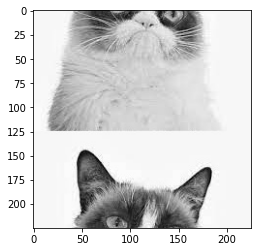

In [5]:
import matplotlib.pyplot as plt
import cv2
img = cv2.imread('shifted_image.jpg')
plt.imshow(img)

In [8]:
import numpy as np
shifted = np.load('shifted.npy')
shifted = [cv2.cvtColor(img, cv2.COLOR_GRAY2BGR) for img in shifted]

In [9]:
from moviepy.editor import ImageSequenceClip
clip = ImageSequenceClip(shifted, fps=20)
clip.write_gif('shifted.gif', fps=20)


[MoviePy] Building file shifted.gif with imageio


100%|██████████| 100/100 [00:33<00:00,  3.03it/s]


In [10]:
from IPython.display import display, Image
Image('test.gif', embed=True)

ValueError: ignored

Unfortunately I didn't realise how to attach gif in notebook but you can find it in applied materials

In [11]:
from tqdm.notebook import tqdm
processes = np.arange(1, 10, 1)

for n in tqdm(processes):
    ! mpirun --allow-run-as-root -np $n python shift.py 'up' 100

  0%|          | 0/9 [00:01<?, ?it/s]

size is 1 time is 2.103085414000816
size is 2 time is 2.3507190450000053
size is 3 time is 2.5552045660006115
size is 4 time is 5.603734937998524
size is 5 time is 4.836687850998715
size is 6 time is 13.055221378999704
size is 7 time is 18.52375163099714
size is 8 time is 8.360722086999886
size is 9 time is 11.155296895001811


In [12]:
times = [2.103085414000816 ,
2.3507190450000053,
2.5552045660006115,
5.603734937998524 ,
4.836687850998715 ,
13.055221378999704,
18.52375163099714 ,
8.360722086999886 , 11.155296895001811]

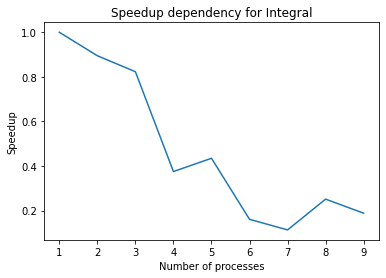

In [13]:
plt.plot(processes, [times[0] / time for time in times])
plt.xlabel('Number of processes')
plt.ylabel('Speedup')
plt.title('Speedup dependency for Integral')
plt.show()

In [14]:
!mpiexec  --allow-run-as-root -n 1  python3 -m mprof run --include-children shift.py 'left' 300

mprof.py: Sampling memory every 0.1s
running new process
running as a Python program...
size is 1 time is 9.403272698000364
